In [1]:
# Import required libraries
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os

# Create cache directory if it doesn't exist
cache_dir = '/tmp/fastf1_cache'
os.makedirs(cache_dir, exist_ok=True)
fastf1.Cache.enable_cache(cache_dir)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Qatar 2025 Qualifying Session

In [2]:
# Load Qatar 2025 Qualifying session to explore sector data
print("Loading Qatar 2025 Qualifying session...")
qatar_quali = fastf1.get_session(2025, 'Qatar', 'Q')
qatar_quali.load()

print(f"✓ Session loaded: {qatar_quali.event['EventName']} - {qatar_quali.name}")
print(f"Total laps in session: {len(qatar_quali.laps)}")

# Let's examine what columns are available in the laps data
print("\n" + "="*80)
print("AVAILABLE COLUMNS IN LAPS DATA:")
print("="*80)
for col in sorted(qatar_quali.laps.columns):
    print(f"  - {col}")
print("="*80)

Loading Qatar 2025 Qualifying session...


events      WARNING 	Correcting user input 'Qatar' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Qualifying [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing d

✓ Session loaded: Qatar Grand Prix - Qualifying
Total laps in session: 358

AVAILABLE COLUMNS IN LAPS DATA:
  - Compound
  - Deleted
  - DeletedReason
  - Driver
  - DriverNumber
  - FastF1Generated
  - FreshTyre
  - IsAccurate
  - IsPersonalBest
  - LapNumber
  - LapStartDate
  - LapStartTime
  - LapTime
  - PitInTime
  - PitOutTime
  - Position
  - Sector1SessionTime
  - Sector1Time
  - Sector2SessionTime
  - Sector2Time
  - Sector3SessionTime
  - Sector3Time
  - SpeedFL
  - SpeedI1
  - SpeedI2
  - SpeedST
  - Stint
  - Team
  - Time
  - TrackStatus
  - TyreLife


## 2. Explore Available Sector Data

In [3]:
# Check for sector and mini sector columns
print("="*80)
print("SECTOR DATA AVAILABILITY CHECK:")
print("="*80)

# Check for sector times
sector_cols = [col for col in qatar_quali.laps.columns if 'sector' in col.lower()]
print(f"\nSector-related columns found: {len(sector_cols)}")
for col in sector_cols:
    print(f"  ✓ {col}")

# Get a sample lap to inspect data
sample_lap = qatar_quali.laps.iloc[0]
print("\n" + "="*80)
print("SAMPLE LAP DATA (First lap):")
print("="*80)
print(f"Driver: {sample_lap['Driver']}")
print(f"Lap Number: {sample_lap['LapNumber']}")
print(f"Lap Time: {sample_lap['LapTime']}")

# Check sector times
if 'Sector1Time' in qatar_quali.laps.columns:
    print(f"Sector 1: {sample_lap['Sector1Time']}")
if 'Sector2Time' in qatar_quali.laps.columns:
    print(f"Sector 2: {sample_lap['Sector2Time']}")
if 'Sector3Time' in qatar_quali.laps.columns:
    print(f"Sector 3: {sample_lap['Sector3Time']}")

# Check for session atoms/mini sectors
print("\n" + "="*80)
print("Checking for telemetry and mini sector data...")
print("="*80)

# Try to get telemetry for a lap
try:
    telemetry = sample_lap.get_telemetry()
    print(f"✓ Telemetry available with {len(telemetry)} data points")
    print(f"Telemetry columns: {list(telemetry.columns)}")
except Exception as e:
    print(f"✗ Telemetry error: {e}")

SECTOR DATA AVAILABILITY CHECK:

Sector-related columns found: 6
  ✓ Sector1Time
  ✓ Sector2Time
  ✓ Sector3Time
  ✓ Sector1SessionTime
  ✓ Sector2SessionTime
  ✓ Sector3SessionTime

SAMPLE LAP DATA (First lap):
Driver: PIA
Lap Number: 1.0
Lap Time: NaT
Sector 1: NaT
Sector 2: 0 days 00:00:35.764000
Sector 3: 0 days 00:00:31.537000

Checking for telemetry and mini sector data...
✓ Telemetry available with 795 data points
Telemetry columns: ['Date', 'SessionTime', 'DriverAhead', 'DistanceToDriverAhead', 'Time', 'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Source', 'Distance', 'RelativeDistance', 'Status', 'X', 'Y', 'Z']


## 3. Theoretical Fastest Lap Calculation

Calculate theoretical fastest lap by stitching together best sectors from different laps.

In [4]:
# Function to find theoretical fastest lap using best sectors
def calculate_theoretical_fastest_lap(driver_laps):
    """
    Calculate theoretical fastest lap from best sectors across all laps.
    
    Parameters:
    driver_laps: DataFrame of laps for a single driver
    
    Returns:
    Dictionary with theoretical lap time and sector breakdown
    """
    # Filter out invalid laps
    valid_laps = driver_laps[
        (driver_laps['Sector1Time'].notna()) & 
        (driver_laps['Sector2Time'].notna()) & 
        (driver_laps['Sector3Time'].notna())
    ].copy()
    
    if len(valid_laps) == 0:
        return None
    
    # Find fastest sectors
    fastest_s1 = valid_laps['Sector1Time'].min()
    fastest_s2 = valid_laps['Sector2Time'].min()
    fastest_s3 = valid_laps['Sector3Time'].min()
    
    # Calculate theoretical lap time
    theoretical_time = fastest_s1 + fastest_s2 + fastest_s3
    
    # Get actual fastest lap
    actual_fastest = valid_laps['LapTime'].min()
    
    # Find which laps had the fastest sectors
    s1_lap = valid_laps[valid_laps['Sector1Time'] == fastest_s1]['LapNumber'].iloc[0]
    s2_lap = valid_laps[valid_laps['Sector2Time'] == fastest_s2]['LapNumber'].iloc[0]
    s3_lap = valid_laps[valid_laps['Sector3Time'] == fastest_s3]['LapNumber'].iloc[0]
    
    return {
        'theoretical_time': theoretical_time,
        'actual_fastest': actual_fastest,
        'time_delta': theoretical_time - actual_fastest,
        'fastest_s1': fastest_s1,
        'fastest_s2': fastest_s2,
        'fastest_s3': fastest_s3,
        's1_lap_num': s1_lap,
        's2_lap_num': s2_lap,
        's3_lap_num': s3_lap,
        'same_lap': (s1_lap == s2_lap == s3_lap)
    }

print("✓ Function 'calculate_theoretical_fastest_lap()' defined")

✓ Function 'calculate_theoretical_fastest_lap()' defined


## 4. Analyze All Drivers

In [5]:
# Analyze all drivers in Qatar 2025 Qualifying
print("="*100)
print("QATAR 2025 QUALIFYING - THEORETICAL FASTEST LAP ANALYSIS")
print("="*100)

results = []

# Get all unique drivers
drivers = sorted(qatar_quali.laps['Driver'].unique())

for driver in drivers:
    driver_laps = qatar_quali.laps[qatar_quali.laps['Driver'] == driver]
    
    result = calculate_theoretical_fastest_lap(driver_laps)
    
    if result:
        results.append({
            'Driver': driver,
            'Actual_Fastest': result['actual_fastest'],
            'Theoretical_Fastest': result['theoretical_time'],
            'Time_Delta': result['time_delta'],
            'Delta_ms': result['time_delta'].total_seconds() * 1000,
            'Same_Lap': result['same_lap'],
            'S1': result['fastest_s1'],
            'S2': result['fastest_s2'],
            'S3': result['fastest_s3'],
            'S1_Lap': result['s1_lap_num'],
            'S2_Lap': result['s2_lap_num'],
            'S3_Lap': result['s3_lap_num']
        })

# Create DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Actual_Fastest')

print(f"\nAnalyzed {len(results_df)} drivers\n")
print(results_df.to_string(index=False))
print("\n" + "="*100)

QATAR 2025 QUALIFYING - THEORETICAL FASTEST LAP ANALYSIS

Analyzed 20 drivers

Driver         Actual_Fastest    Theoretical_Fastest               Time_Delta  Delta_ms  Same_Lap                     S1                     S2                     S3  S1_Lap  S2_Lap  S3_Lap
   PIA 0 days 00:01:19.387000 0 days 00:01:19.385000 -1 days +23:59:59.998000      -2.0     False 0 days 00:00:29.209000 0 days 00:00:26.919000 0 days 00:00:23.257000    17.0    17.0    14.0
   NOR 0 days 00:01:19.495000 0 days 00:01:19.495000          0 days 00:00:00       0.0      True 0 days 00:00:29.212000 0 days 00:00:26.978000 0 days 00:00:23.305000    14.0    14.0    14.0
   VER 0 days 00:01:19.651000 0 days 00:01:19.651000          0 days 00:00:00       0.0      True 0 days 00:00:29.160000 0 days 00:00:27.064000 0 days 00:00:23.427000    22.0    22.0    22.0
   RUS 0 days 00:01:19.662000 0 days 00:01:19.630000 -1 days +23:59:59.968000     -32.0     False 0 days 00:00:29.214000 0 days 00:00:26.987000 0 days 00:00:

## 5. Detailed Breakdown - Top 5 Drivers

In [6]:
# Detailed analysis for top 5 drivers
print("="*100)
print("DETAILED BREAKDOWN - TOP 5 DRIVERS")
print("="*100)

top_5_drivers = results_df.head(5)['Driver'].tolist()

for driver in top_5_drivers:
    driver_data = results_df[results_df['Driver'] == driver].iloc[0]
    
    print(f"\n{'─'*100}")
    print(f"🏎️  {driver}")
    print(f"{'─'*100}")
    print(f"Actual Fastest Lap:       {driver_data['Actual_Fastest']}")
    print(f"Theoretical Fastest Lap:  {driver_data['Theoretical_Fastest']}")
    print(f"Time Delta:               {driver_data['Delta_ms']:.3f} ms")
    print(f"All sectors in same lap:  {'✓ YES' if driver_data['Same_Lap'] else '✗ NO'}")
    print(f"\nBest Sectors:")
    print(f"  Sector 1: {driver_data['S1']} (Lap {driver_data['S1_Lap']})")
    print(f"  Sector 2: {driver_data['S2']} (Lap {driver_data['S2_Lap']})")
    print(f"  Sector 3: {driver_data['S3']} (Lap {driver_data['S3_Lap']})")
    
    if not driver_data['Same_Lap']:
        print(f"\n  💡 Could have been {driver_data['Delta_ms']:.3f} ms faster by stitching sectors!")

print(f"\n{'='*100}")

DETAILED BREAKDOWN - TOP 5 DRIVERS

────────────────────────────────────────────────────────────────────────────────────────────────────
🏎️  PIA
────────────────────────────────────────────────────────────────────────────────────────────────────
Actual Fastest Lap:       0 days 00:01:19.387000
Theoretical Fastest Lap:  0 days 00:01:19.385000
Time Delta:               -2.000 ms
All sectors in same lap:  ✗ NO

Best Sectors:
  Sector 1: 0 days 00:00:29.209000 (Lap 17.0)
  Sector 2: 0 days 00:00:26.919000 (Lap 17.0)
  Sector 3: 0 days 00:00:23.257000 (Lap 14.0)

  💡 Could have been -2.000 ms faster by stitching sectors!

────────────────────────────────────────────────────────────────────────────────────────────────────
🏎️  NOR
────────────────────────────────────────────────────────────────────────────────────────────────────
Actual Fastest Lap:       0 days 00:01:19.495000
Theoretical Fastest Lap:  0 days 00:01:19.495000
Time Delta:               0.000 ms
All sectors in same lap:  ✓ YES


## 6. Explore Mini Sector / Telemetry Data

In [7]:
# Now let's explore mini sectors (if available)
print("="*100)
print("EXPLORING MINI SECTOR / SPEED TRAP DATA")
print("="*100)

# Check if there are speed trap columns
speed_cols = [col for col in qatar_quali.laps.columns if 'speed' in col.lower() or 'trap' in col.lower()]

print(f"\nSpeed-related columns found: {len(speed_cols)}")
for col in speed_cols:
    sample_value = qatar_quali.laps[col].iloc[0] if len(qatar_quali.laps) > 0 else None
    print(f"  ✓ {col}: {sample_value}")

# Check telemetry for more granular data
print("\n" + "="*100)
print("TELEMETRY DATA EXPLORATION (for mini sectors)")
print("="*100)

# Get a fast lap from pole sitter
fastest_lap = qatar_quali.laps.pick_fastest()
print(f"\nFastest lap overall:")
print(f"  Driver: {fastest_lap['Driver']}")
print(f"  Lap Time: {fastest_lap['LapTime']}")
print(f"  Lap Number: {fastest_lap['LapNumber']}")

try:
    # Get telemetry
    tel = fastest_lap.get_telemetry()
    print(f"\n✓ Telemetry loaded: {len(tel)} data points")
    print(f"\nTelemetry columns:")
    for col in tel.columns:
        print(f"  - {col}")
    
    # Check for mini sector markers
    if 'SessionTime' in tel.columns:
        print(f"\n✓ SessionTime available (can be used for micro-sector analysis)")
    if 'Distance' in tel.columns:
        print(f"✓ Distance available (can divide track into custom segments)")
        print(f"  Track length: {tel['Distance'].max():.0f} meters")
    if 'Speed' in tel.columns:
        print(f"✓ Speed data available")
        print(f"  Max speed: {tel['Speed'].max():.1f} km/h")
        print(f"  Min speed: {tel['Speed'].min():.1f} km/h")
    
except Exception as e:
    print(f"\n✗ Error loading telemetry: {e}")

print("\n" + "="*100)

EXPLORING MINI SECTOR / SPEED TRAP DATA

Speed-related columns found: 4
  ✓ SpeedI1: 225.0
  ✓ SpeedI2: 229.0
  ✓ SpeedFL: 284.0
  ✓ SpeedST: 92.0

TELEMETRY DATA EXPLORATION (for mini sectors)

Fastest lap overall:
  Driver: PIA
  Lap Time: 0 days 00:01:19.387000
  Lap Number: 17.0

✓ Telemetry loaded: 609 data points

Telemetry columns:
  - Date
  - SessionTime
  - DriverAhead
  - DistanceToDriverAhead
  - Time
  - RPM
  - Speed
  - nGear
  - Throttle
  - Brake
  - DRS
  - Source
  - Distance
  - RelativeDistance
  - Status
  - X
  - Y
  - Z

✓ SessionTime available (can be used for micro-sector analysis)
✓ Distance available (can divide track into custom segments)
  Track length: 5378 meters
✓ Speed data available
  Max speed: 327.0 km/h
  Min speed: 99.0 km/h



## 7. Create Custom Mini Sectors

Divide the track into custom mini sectors using telemetry distance data.

In [8]:
# Function to create custom mini sectors
def create_mini_sectors(telemetry, num_mini_sectors=10):
    """
    Divide a lap into mini sectors based on distance.
    
    Parameters:
    telemetry: Telemetry data for a lap
    num_mini_sectors: Number of mini sectors to divide the lap into
    
    Returns:
    DataFrame with mini sector times
    """
    if 'Distance' not in telemetry.columns or 'SessionTime' not in telemetry.columns:
        return None
    
    track_length = telemetry['Distance'].max()
    segment_length = track_length / num_mini_sectors
    
    mini_sector_times = []
    
    for i in range(num_mini_sectors):
        start_dist = i * segment_length
        end_dist = (i + 1) * segment_length
        
        # Find telemetry points in this segment
        segment = telemetry[
            (telemetry['Distance'] >= start_dist) & 
            (telemetry['Distance'] < end_dist)
        ]
        
        if len(segment) > 0:
            start_time = segment['SessionTime'].iloc[0]
            end_time = segment['SessionTime'].iloc[-1]
            segment_time = (end_time - start_time).total_seconds()
            
            mini_sector_times.append({
                'MiniSector': i + 1,
                'Start_Dist': start_dist,
                'End_Dist': end_dist,
                'Time_Seconds': segment_time,
                'Avg_Speed': segment['Speed'].mean() if 'Speed' in segment.columns else None
            })
    
    return pd.DataFrame(mini_sector_times)

print("✓ Function 'create_mini_sectors()' defined")

✓ Function 'create_mini_sectors()' defined


In [9]:
# Test mini sector creation on fastest lap
try:
    fastest_lap = qatar_quali.laps.pick_fastest()
    fastest_tel = fastest_lap.get_telemetry()
    
    mini_sectors = create_mini_sectors(fastest_tel, num_mini_sectors=10)
    
    if mini_sectors is not None:
        print("="*100)
        print(f"MINI SECTORS - {fastest_lap['Driver']} (Fastest Lap)")
        print("="*100)
        print(mini_sectors.to_string(index=False))
        print("\n" + "="*100)
        print(f"Total lap time (from mini sectors): {mini_sectors['Time_Seconds'].sum():.3f} seconds")
        print(f"Actual lap time: {fastest_lap['LapTime'].total_seconds():.3f} seconds")
    else:
        print("Could not create mini sectors - missing required data")
        
except Exception as e:
    print(f"Error creating mini sectors: {e}")

MINI SECTORS - PIA (Fastest Lap)
 MiniSector  Start_Dist    End_Dist  Time_Seconds  Avg_Speed
          1    0.000000  537.830491         5.965 313.824020
          2  537.830491 1075.660982         8.390 237.243559
          3 1075.660982 1613.491474         7.590 250.778872
          4 1613.491474 2151.321965         8.170 235.845995
          5 2151.321965 2689.152456        10.800 173.791365
          6 2689.152456 3226.982947         8.560 222.390352
          7 3226.982947 3764.813438         7.040 269.006376
          8 3764.813438 4302.643930         6.640 287.411586
          9 4302.643930 4840.474421         6.770 280.942342
         10 4840.474421 5378.304912         8.220 233.493615

Total lap time (from mini sectors): 78.145 seconds
Actual lap time: 79.387 seconds


## Summary

### What's Available in FastF1:

✅ **Standard Sectors (1, 2, 3)**
- Sector1Time, Sector2Time, Sector3Time are directly available
- Can calculate theoretical fastest lap by stitching best sectors from different laps
- Can identify which laps contributed the best sectors

✅ **Telemetry Data**
- High-frequency data points (typically 4-10 Hz)
- Distance along track
- Speed, throttle, brake, gear, RPM, DRS
- SessionTime for precise timing

✅ **Custom Mini Sectors**
- Not pre-calculated, but can be created from telemetry
- Can divide track into any number of segments
- Can analyze performance in custom track sections

### Analysis Possibilities:
1. Best theoretical lap from stitched sectors (Sector 1, 2, 3)
2. Custom mini-sector analysis (divide track into N segments)
3. Speed trap comparisons at specific distances
4. Micro-sector analysis using telemetry
5. Identify exactly where lap time is gained/lost

## 8. Verstappen Lap Comparison Analysis

Compare mini sector deltas between:
1. **Plot 1**: Qualifying fastest lap vs Race lap 5
2. **Plot 2**: Race lap 5 vs 3rd-to-last race lap

Using color-coded visualization on track position.

In [15]:
# Load Qatar 2025 Race session
print("Loading Qatar 2025 Race session...")
qatar_race = fastf1.get_session(2025, 'Qatar', 'R')
qatar_race.load()

print(f"✓ Race session loaded: {qatar_race.event['EventName']} - {qatar_race.name}")

# Get Verstappen's laps
ver_quali_laps = qatar_quali.laps.pick_drivers('VER')
ver_race_laps = qatar_race.laps.pick_drivers('VER')

print(f"\nVerstappen's laps in qualifying: {len(ver_quali_laps)}")
print(f"Verstappen's laps in race: {len(ver_race_laps)}")

# Get specific laps
fastest_quali_lap = ver_quali_laps.pick_fastest()
race_lap_5 = ver_race_laps[ver_race_laps['LapNumber'] == 5].iloc[0]
third_last_lap_num = ver_race_laps['LapNumber'].max() - 2
race_lap_third_last = ver_race_laps[ver_race_laps['LapNumber'] == third_last_lap_num].iloc[0]

print(f"\n✓ Selected laps:")
print(f"  Quali fastest: Lap {fastest_quali_lap['LapNumber']} - {fastest_quali_lap['LapTime']}")
print(f"  Race lap 5: {race_lap_5['LapTime']}")
print(f"  Race lap {third_last_lap_num} (3rd to last): {race_lap_third_last['LapTime']}")

Loading Qatar 2025 Race session...


events      WARNING 	Correcting user input 'Qatar' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '55', '4', '12', '63', '14', '16', '30', '22', '23', '44', '5', '43', '31', '10', '18', '6', '87

✓ Race session loaded: Qatar Grand Prix - Race

Verstappen's laps in qualifying: 23
Verstappen's laps in race: 57

✓ Selected laps:
  Quali fastest: Lap 22.0 - 0 days 00:01:19.651000
  Race lap 5: 0 days 00:01:26.843000
  Race lap 55.0 (3rd to last): 0 days 00:01:24.405000


In [16]:
# Function to create mini sectors with telemetry from two laps and calculate deltas
def compare_mini_sectors_with_telemetry(lap1, lap2, num_mini_sectors=20):
    """
    Compare two laps by creating mini sectors and calculating time deltas.
    
    Parameters:
    lap1: Reference lap (faster/baseline)
    lap2: Comparison lap
    num_mini_sectors: Number of mini sectors to divide the lap into
    
    Returns:
    DataFrame with mini sector comparison data including X, Y positions
    """
    # Get telemetry for both laps
    tel1 = lap1.get_telemetry()
    tel2 = lap2.get_telemetry()
    
    # Add distance if not present
    tel1 = tel1.add_distance()
    tel2 = tel2.add_distance()
    
    track_length = tel1['Distance'].max()
    segment_length = track_length / num_mini_sectors
    
    comparison_data = []
    
    for i in range(num_mini_sectors):
        start_dist = i * segment_length
        end_dist = (i + 1) * segment_length
        mid_dist = (start_dist + end_dist) / 2
        
        # Get segments from both laps
        seg1 = tel1[(tel1['Distance'] >= start_dist) & (tel1['Distance'] < end_dist)]
        seg2 = tel2[(tel2['Distance'] >= start_dist) & (tel2['Distance'] < end_dist)]
        
        if len(seg1) > 0 and len(seg2) > 0:
            # Calculate time for each segment
            time1 = (seg1['SessionTime'].iloc[-1] - seg1['SessionTime'].iloc[0]).total_seconds()
            time2 = (seg2['SessionTime'].iloc[-1] - seg2['SessionTime'].iloc[0]).total_seconds()
            
            # Get middle point coordinates for plotting
            mid_idx1 = len(seg1) // 2
            x_pos = seg1['X'].iloc[mid_idx1] if 'X' in seg1.columns else mid_dist
            y_pos = seg1['Y'].iloc[mid_idx1] if 'Y' in seg1.columns else 0
            
            # Calculate delta (lap2 - lap1, positive means lap2 is slower)
            delta_seconds = time2 - time1
            delta_ms = delta_seconds * 1000
            
            comparison_data.append({
                'MiniSector': i + 1,
                'Start_Dist': start_dist,
                'End_Dist': end_dist,
                'Mid_Dist': mid_dist,
                'X': x_pos,
                'Y': y_pos,
                'Lap1_Time': time1,
                'Lap2_Time': time2,
                'Delta_Seconds': delta_seconds,
                'Delta_MS': delta_ms
            })
    
    return pd.DataFrame(comparison_data)

print("✓ Function 'compare_mini_sectors_with_telemetry()' defined")

✓ Function 'compare_mini_sectors_with_telemetry()' defined


In [ ]:
# Function to plot mini sector comparison with color-coded deltas - FULL TRACK VISUALIZATION
def plot_mini_sector_comparison(comparison_df, lap1, lap2, lap1_name, lap2_name, title, filename):
    """
    Create Instagram-ready visualization of mini sector time deltas with full track shape.
    
    Parameters:
    comparison_df: DataFrame from compare_mini_sectors_with_telemetry
    lap1: First lap object (to get full telemetry for track shape)
    lap2: Second lap object
    lap1_name: Name/description of first lap (baseline)
    lap2_name: Name/description of second lap
    title: Plot title
    filename: Output filename
    """
    fig, ax = plt.subplots(figsize=(20, 16), facecolor='#1a1a1a')
    ax.set_facecolor('#0a0a0a')
    
    # Get full telemetry from lap 1 to draw the track
    tel1 = lap1.get_telemetry()
    tel1 = tel1.add_distance()
    
    # Calculate total time difference
    total_delta = comparison_df['Delta_MS'].sum()
    
    # Create color map (blue = faster, red = slower)
    max_abs_delta = comparison_df['Delta_MS'].abs().max()
    
    # Create custom colormap
    from matplotlib.colors import LinearSegmentedColormap, Normalize
    colors = ['#0000FF', '#3366FF', '#6699FF', '#99CCFF', '#FFFFFF', '#FFCC99', '#FF9966', '#FF6633', '#FF0000']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('delta_map', colors, N=n_bins)
    norm = Normalize(vmin=-max_abs_delta, vmax=max_abs_delta)
    
    # Assign each telemetry point to a mini sector and get its delta
    track_length = tel1['Distance'].max()
    num_mini_sectors = len(comparison_df)
    segment_length = track_length / num_mini_sectors
    
    # Plot each mini sector as a thick colored line segment
    from matplotlib.collections import LineCollection
    
    for _, row in comparison_df.iterrows():
        mini_sector_num = int(row['MiniSector'])
        start_dist = row['Start_Dist']
        end_dist = row['End_Dist']
        delta_ms = row['Delta_MS']
        
        # Get all telemetry points in this mini sector
        sector_tel = tel1[(tel1['Distance'] >= start_dist) & (tel1['Distance'] < end_dist)]
        
        if len(sector_tel) > 0:
            # Create line segments for this mini sector
            points = np.array([sector_tel['X'].values, sector_tel['Y'].values]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            
            # Get color for this delta value
            color = cmap(norm(delta_ms))
            
            # Create LineCollection with thick lines
            lc = LineCollection(segments, colors=color, linewidths=8, alpha=0.95, 
                              capstyle='round', joinstyle='round', zorder=3)
            ax.add_collection(lc)
    
    # Create a dummy scatter for colorbar
    scatter = ax.scatter([], [], c=[], cmap=cmap, norm=norm)
    
    # Add mini sector numbers and delta values as text annotations
    for _, row in comparison_df.iterrows():
        # Mini sector number (white, bold, larger) with background
        ax.text(row['X'], row['Y'], f"{int(row['MiniSector'])}", 
                ha='center', va='center', fontsize=22, fontweight='bold',
                color='white', zorder=10,
                bbox=dict(boxstyle='circle', facecolor='black', alpha=0.7, 
                         edgecolor='white', linewidth=2, pad=0.4))
        
        # Delta value below the sector number (with sign and background)
        delta_text = f"{row['Delta_MS']:+.0f}" if abs(row['Delta_MS']) >= 1 else f"{row['Delta_MS']:+.1f}"
        y_offset = (max(comparison_df['Y']) - min(comparison_df['Y'])) * 0.025
        ax.text(row['X'], row['Y'] - y_offset, delta_text, 
                ha='center', va='top', fontsize=16, fontweight='bold',
                color='yellow', zorder=10,
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.8, 
                         edgecolor='yellow', linewidth=1.5, pad=0.3))
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, pad=0.02, fraction=0.046)
    cbar.set_label('Time Delta (ms)\n← Lap 2 Faster | Lap 2 Slower →', 
                   fontsize=16, fontweight='bold', color='white')
    cbar.ax.tick_params(labelsize=14, colors='white', width=2, length=6)
    cbar.outline.set_edgecolor('white')
    cbar.outline.set_linewidth(2)
    
    # Title
    ax.set_title(title, fontsize=26, fontweight='bold', pad=30, color='white')
    
    # Add comparison info box
    info_text = f'BASELINE:\n{lap1_name}\n\nCOMPARISON:\n{lap2_name}\n\nTotal Δ: {total_delta:+.0f} ms'
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
            fontsize=18, verticalalignment='top', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='black', alpha=0.85, 
                     edgecolor='white', linewidth=3, pad=0.8),
            color='white', linespacing=1.5)
    
    # Legend for colors and symbols
    legend_text = '🔵 Blue: Lap 2 FASTER\n⚪ White: EQUAL pace\n🔴 Red: Lap 2 SLOWER\n\n⚫ Numbers: Mini Sector\n🟡 Yellow: Δ in ms'
    ax.text(0.98, 0.98, legend_text, transform=ax.transAxes,
            fontsize=16, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='black', alpha=0.85, 
                     edgecolor='white', linewidth=3, pad=0.8),
            color='white', linespacing=1.5, fontweight='bold')
    
    # Remove axis ticks but keep frame
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    
    # Equal aspect ratio for proper track shape
    ax.set_aspect('equal')
    
    # Make frame more prominent
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        spine.set_linewidth(3)
    
    plt.tight_layout()
    plt.savefig(f'../f1_visualizations/{filename}', dpi=300, bbox_inches='tight', facecolor='#1a1a1a')
    plt.show()
    
    print(f"✓ Plot saved: ../f1_visualizations/{filename}")

print("✓ Function 'plot_mini_sector_comparison()' defined - F1 GRADE VISUALIZATION")

✓ Function 'plot_mini_sector_comparison()' defined - F1 GRADE VISUALIZATION


### Plot 1: Qualifying Fastest Lap vs Race Lap 5

Comparing Verstappen's Qualifying fastest lap vs Race lap 5...

Mini Sectors Created: 20

Total lap time difference: 6672 ms
Quali lap: 0 days 00:01:19.651000
Race lap 5: 0 days 00:01:26.843000

Mini Sector Deltas:
 MiniSector  Delta_MS
          1     169.0
          2      40.0
          3     639.0
          4     851.0
          5     320.0
          6      99.0
          7     321.0
          8     699.0
          9     382.0
         10     778.0
         11     301.0
         12     749.0
         13     149.0
         14      11.0
         15     291.0
         16     419.0
         17    -119.0
         18     190.0
         19     447.0
         20     -64.0


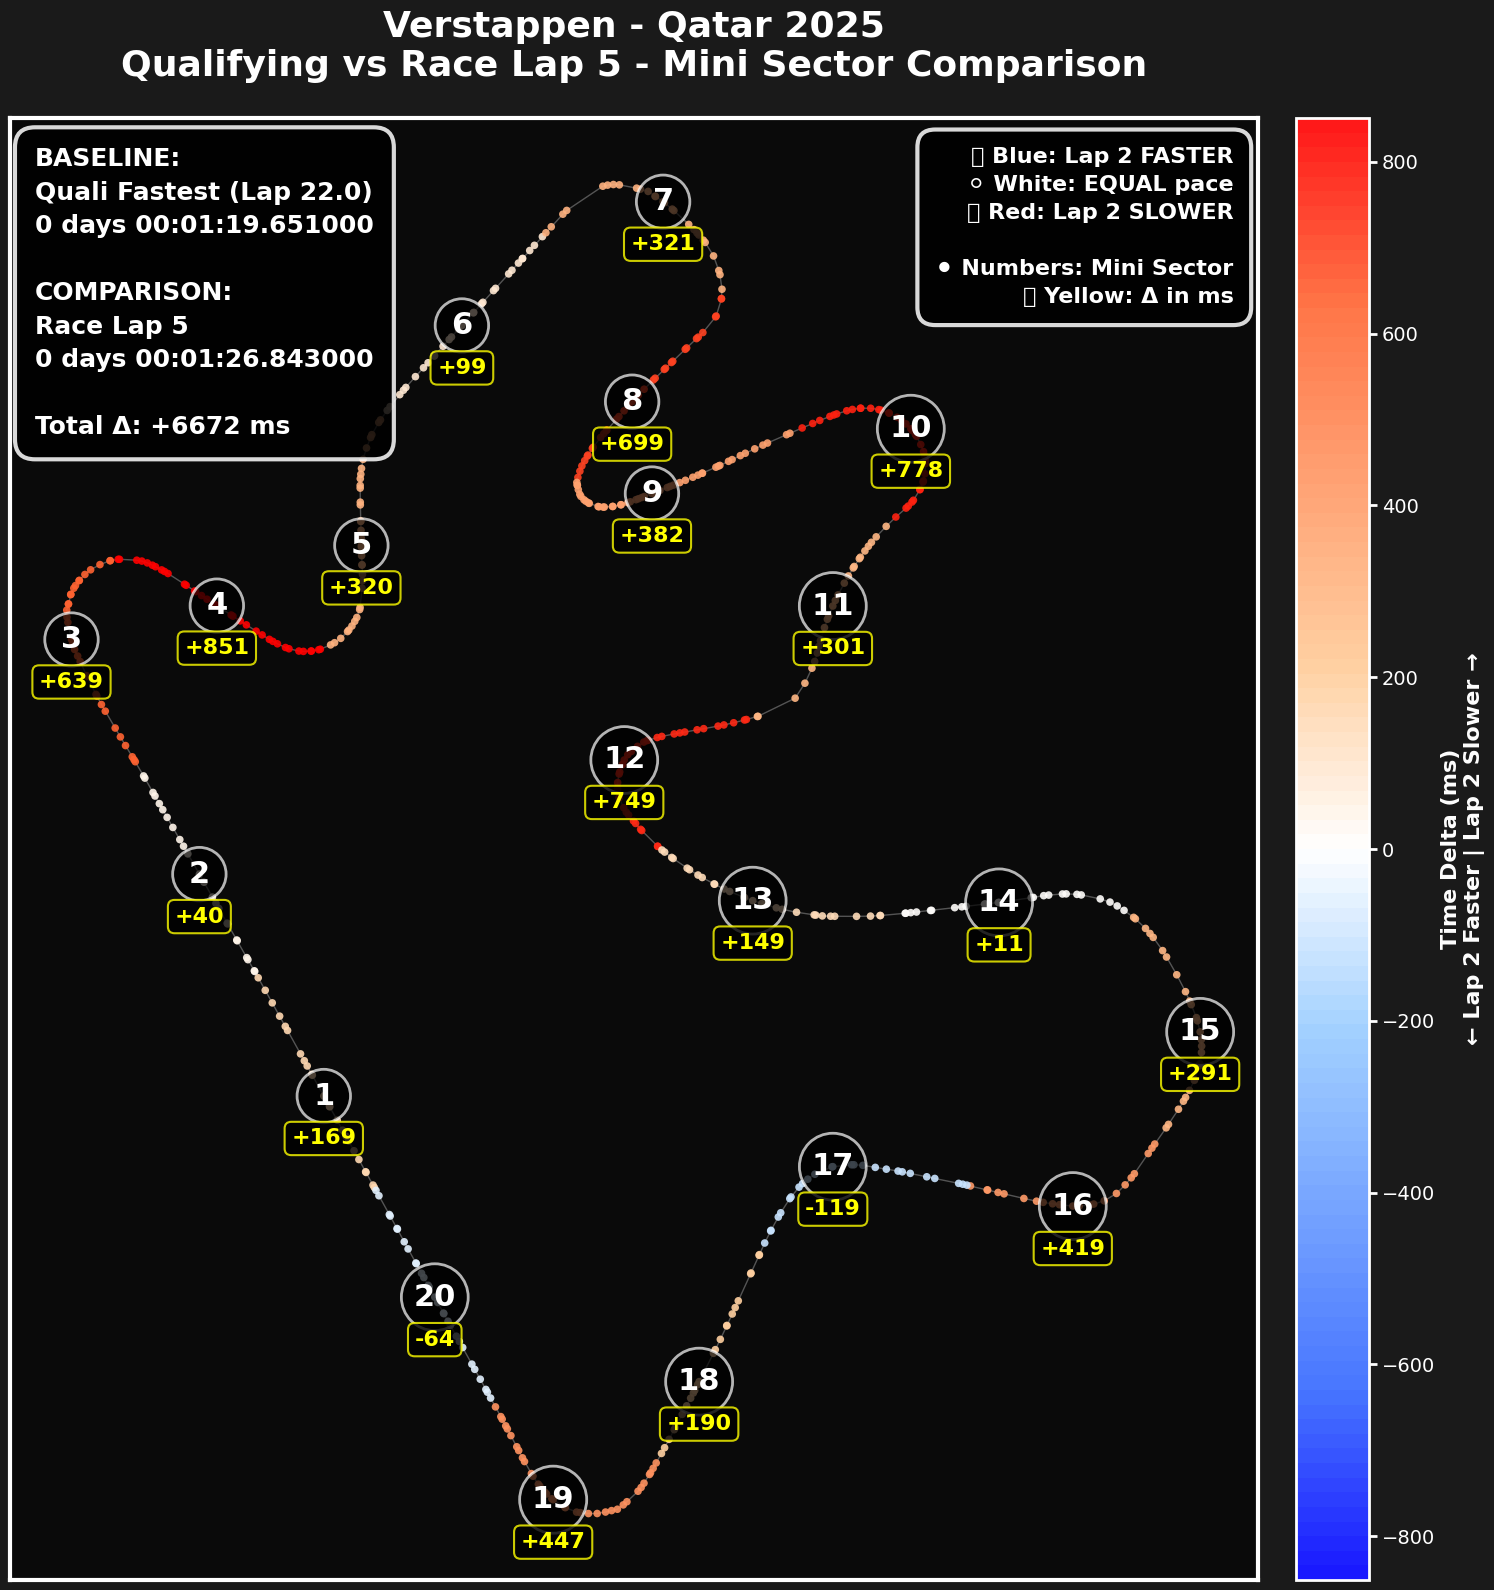

✓ Plot saved: ../f1_visualizations/verstappen_quali_vs_race5_qatar2025.png


In [18]:
# Compare Quali fastest lap vs Race lap 5
print("Comparing Verstappen's Qualifying fastest lap vs Race lap 5...")
print("="*80)

comparison_1 = compare_mini_sectors_with_telemetry(
    fastest_quali_lap, 
    race_lap_5, 
    num_mini_sectors=20
)

print(f"\nMini Sectors Created: {len(comparison_1)}")
print(f"\nTotal lap time difference: {comparison_1['Delta_MS'].sum():.0f} ms")
print(f"Quali lap: {fastest_quali_lap['LapTime']}")
print(f"Race lap 5: {race_lap_5['LapTime']}")

print("\nMini Sector Deltas:")
print(comparison_1[['MiniSector', 'Delta_MS']].to_string(index=False))

# Create visualization
plot_mini_sector_comparison(
    comparison_1,
    fastest_quali_lap,
    race_lap_5,
    lap1_name=f"Quali Fastest (Lap {fastest_quali_lap['LapNumber']})\n{fastest_quali_lap['LapTime']}",
    lap2_name=f"Race Lap 5\n{race_lap_5['LapTime']}",
    title="Verstappen - Qatar 2025\nQualifying vs Race Lap 5 - Mini Sector Comparison",

    filename="verstappen_quali_vs_race5_qatar2025.png")

### Plot 2: Race Lap 5 vs 3rd-to-Last Race Lap

Comparing Verstappen's Race lap 5 vs Race lap 55.0 (3rd to last)...



Mini Sectors Created: 20

Total lap time difference: -3037 ms
Race lap 5: 0 days 00:01:26.843000
Race lap 55.0: 0 days 00:01:24.405000

Mini Sector Deltas:
 MiniSector  Delta_MS
          1     -81.0
          2       0.0
          3    -240.0
          4    -292.0
          5     159.0
          6    -119.0
          7    -533.0
          8    -140.0
          9    -204.0
         10    -201.0
         11    -104.0
         12    -128.0
         13     -28.0
         14     -91.0
         15    -790.0
         16     -47.0
         17     359.0
         18    -252.0
         19    -248.0
         20     -57.0


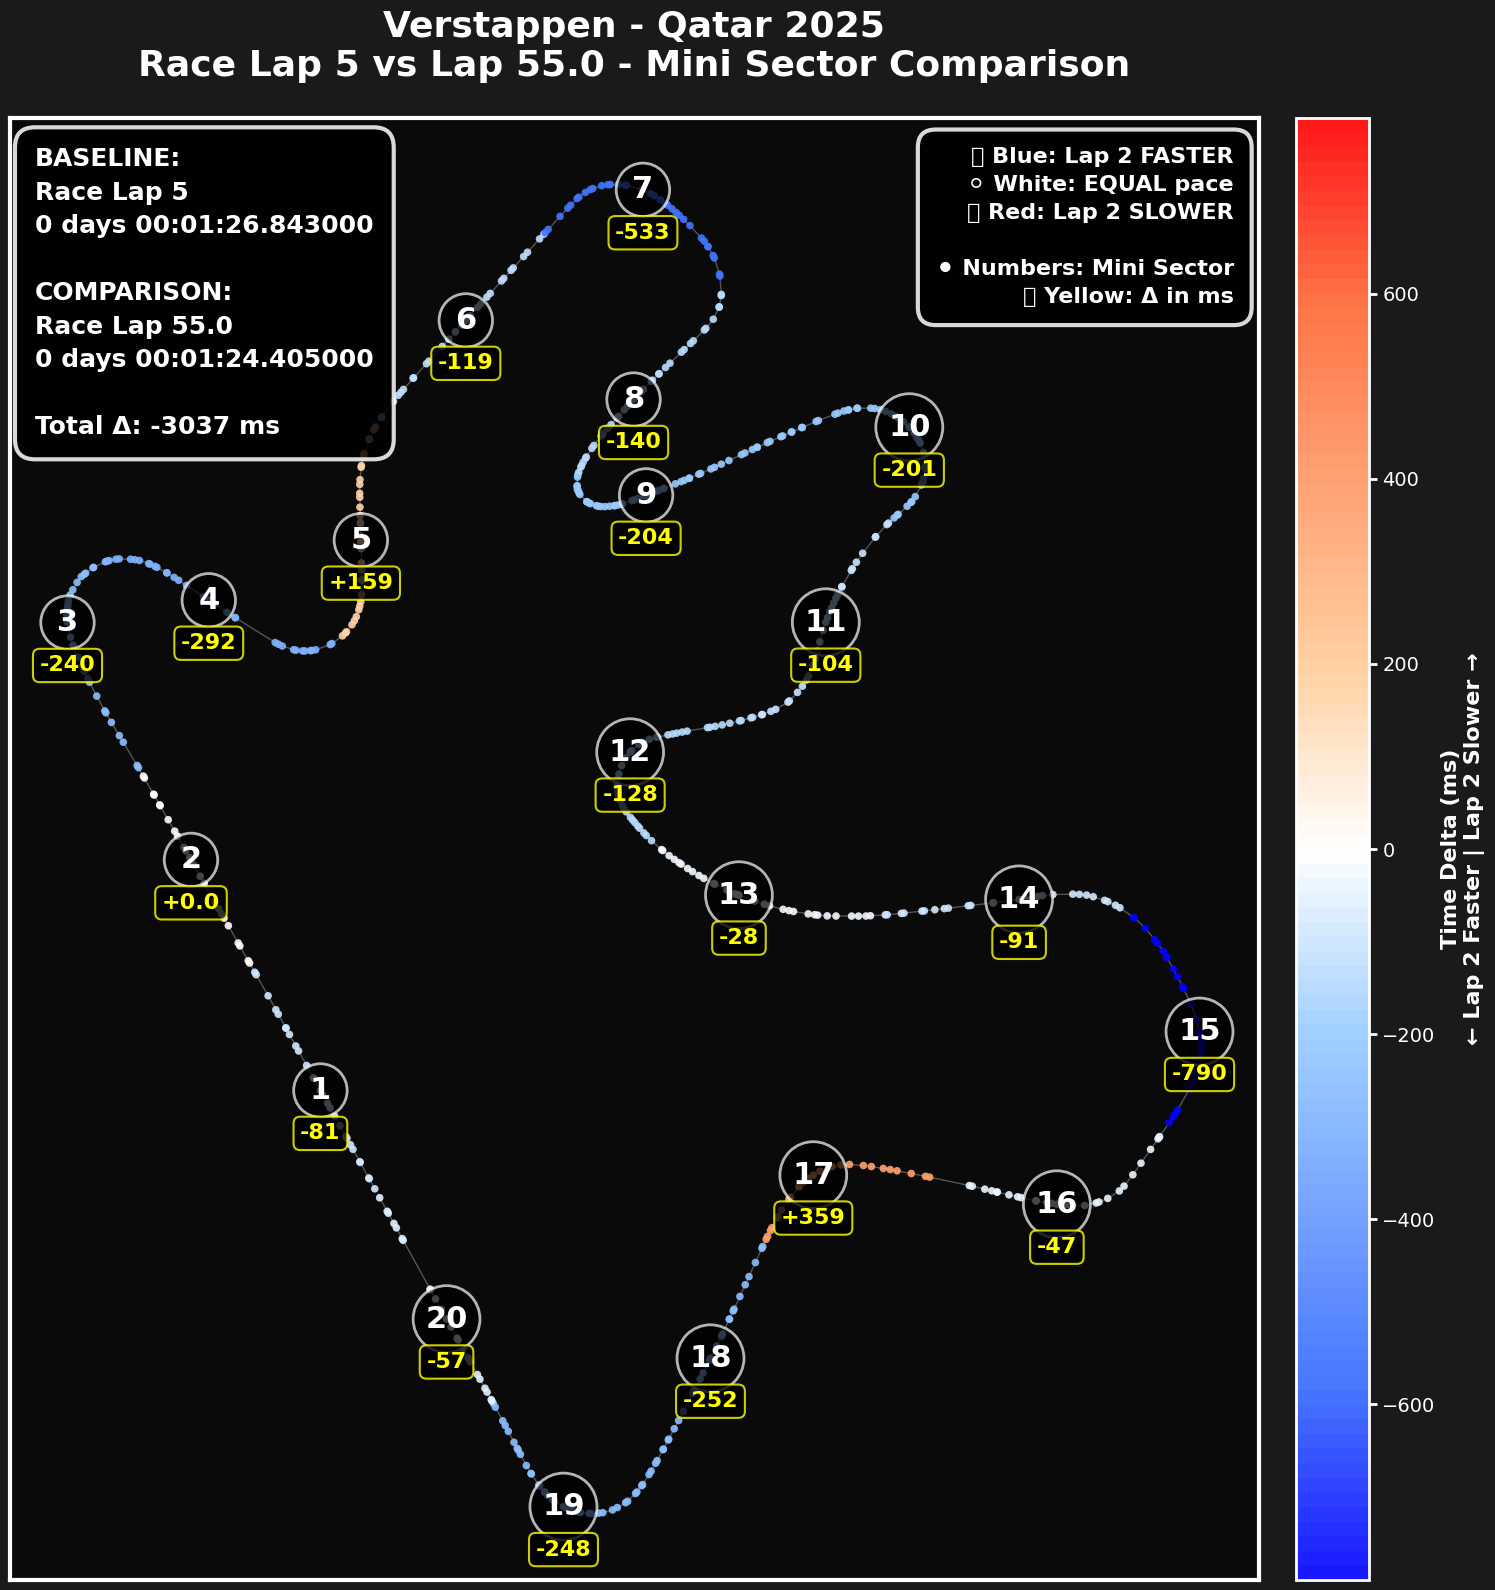

✓ Plot saved: ../f1_visualizations/verstappen_race5_vs_late_race_qatar2025.png


In [19]:
# Compare Race lap 5 vs 3rd-to-last race lap
print(f"Comparing Verstappen's Race lap 5 vs Race lap {third_last_lap_num} (3rd to last)...")
print("="*80)

comparison_2 = compare_mini_sectors_with_telemetry(
    race_lap_5, 
    race_lap_third_last, 
    num_mini_sectors=20
)

print(f"\nMini Sectors Created: {len(comparison_2)}")
print(f"\nTotal lap time difference: {comparison_2['Delta_MS'].sum():.0f} ms")
print(f"Race lap 5: {race_lap_5['LapTime']}")
print(f"Race lap {third_last_lap_num}: {race_lap_third_last['LapTime']}")

print("\nMini Sector Deltas:")
print(comparison_2[['MiniSector', 'Delta_MS']].to_string(index=False))

# Create visualization
plot_mini_sector_comparison(
    comparison_2,
    race_lap_5,
    race_lap_third_last,
    lap1_name=f"Race Lap 5\n{race_lap_5['LapTime']}",
    lap2_name=f"Race Lap {third_last_lap_num}\n{race_lap_third_last['LapTime']}",
    title=f"Verstappen - Qatar 2025\nRace Lap 5 vs Lap {third_last_lap_num} - Mini Sector Comparison",

    filename="verstappen_race5_vs_late_race_qatar2025.png")

### Analysis Summary

The visualizations show:

**Plot 1 - Quali vs Race Lap 5:**
- Compares low-fuel qualifying pace vs early race pace (with fuel load)
- Red mini sectors: Race lap was slower (expected due to fuel)
- Blue mini sectors: Race lap was surprisingly faster (if any)
- Shows where the fuel load has most impact on lap time

**Plot 2 - Race Lap 5 vs Late Race:**
- Compares fresh tyres (lap 5) vs worn tyres (late race)
- Red mini sectors: Tyre degradation impact zones
- Blue mini sectors: Improved pace (fuel burn-off effect vs tyre deg)
- Shows the balance between fuel weight reduction and tyre wear

**Visualization Features:**
- Mini sector numbers in white
- Delta values in yellow (milliseconds)
- Color gradient: Blue (faster) → White (equal) → Red (slower)
- Total time difference in info box
- Instagram-ready format (dark theme, high contrast)